### MNIST handwritten digit recognition
###### Harsh Raj, 24AI06014

In [1]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from early_stopping_pytorch import EarlyStopping

In [22]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 6GB Laptop GPU
Using device: cuda


##### Data transformation and normalization

In [ ]:
# The MNIST dataset consists of 60,000 training images and 10,000 test images of handwritten digits (0-9).
# Following transformations are required (convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# normalize to [-1, 1] range
# The pixel values in MNIST images range from 0 to 255, so we normalize them to the range [-1, 1] for better training performance.
# This is done by subtracting 0.5 from each pixel value and then dividing by 0.5.
# This transformation helps the model to converge faster during training.
# Define the neural network architecture
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders (to pass batch of 64 images at once)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

##### Model architecture
| Layer | Describe |
| -- | -- |
| Layer 1 | Fully connected layer 1 |
| Layer 2 | Fully connected layer 2 |
| Layer 3 | Fully connected layer 3 |
| Layer 4 | Output layer |

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Fully connected layer (input: 784, output: 128)
        self.fc2 = nn.Linear(128, 64)     # Hidden layer
        self.fc3 = nn.Linear(64, 32)      # Hidden layer
        self.fc4 = nn.Linear(32, 10)      # Output layer (10 classes)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function (logits)
        return x

# Initialize the model
model = NeuralNet()
model.to(device)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

##### Loss function

In [41]:
criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1) # Learning rate scheduler
early_stopping = EarlyStopping(patience=5, verbose=True) # Early stopping to prevent overfitting

##### Training

In [42]:
num_epochs = 20  # number of training epochs
train_loss = {}
validation_loss = {}
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # reset gradients
        outputs = model(images)  # forward pass
        loss = criterion(outputs, labels)  # compute loss
        loss.backward()  # backpropagation
        optimizer.step()  # update model weights

        running_loss += loss.item()

    loss = running_loss / len(train_loader)
    train_loss[epoch] = loss

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss}")

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss = {val_loss / len(val_loader):.4f}")

    validation_loss[epoch] = val_loss / len(val_loader)

    # Early stopping check
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    model.train()  # set model back to training mode
    
    scheduler.step() # adjust learning rate

    print()


Epoch 1/20, Loss: 0.49707027849555013
Epoch 1/20, Validation Loss = 0.2741
Validation loss decreased (inf --> 51.538535).  Saving model ...

Epoch 2/20, Loss: 0.22750177623331547
Epoch 2/20, Validation Loss = 0.2096
Validation loss decreased (51.538535 --> 39.399418).  Saving model ...

Epoch 3/20, Loss: 0.16354943382988374
Epoch 3/20, Validation Loss = 0.1565
Validation loss decreased (39.399418 --> 29.427670).  Saving model ...

Epoch 4/20, Loss: 0.12849501896773777
Epoch 4/20, Validation Loss = 0.1331
Validation loss decreased (29.427670 --> 25.032052).  Saving model ...

Epoch 5/20, Loss: 0.1090391544898351
Epoch 5/20, Validation Loss = 0.1231
Validation loss decreased (25.032052 --> 23.148350).  Saving model ...

Epoch 6/20, Loss: 0.0914992586011067
Epoch 6/20, Validation Loss = 0.1454
EarlyStopping counter: 1 out of 5

Epoch 7/20, Loss: 0.08537794827794035
Epoch 7/20, Validation Loss = 0.1029
Validation loss decreased (23.148350 --> 19.354090).  Saving model ...

Epoch 8/20, Loss

##### Loss curve

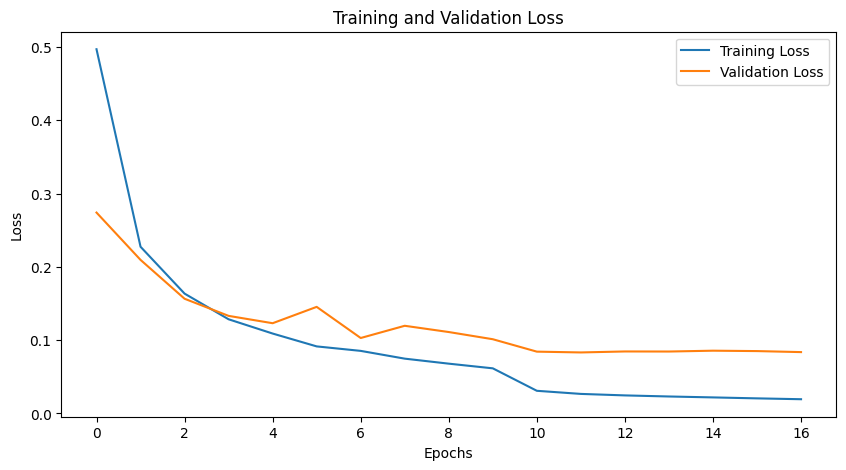

In [43]:
plt.figure(figsize=(10, 5))
losses = [train_loss[i] for i in range(len(train_loss))]
plt.plot(losses, label='Training Loss')
val_losses = [validation_loss[i] for i in range(len(validation_loss))]
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

##### Evaluation (Test accuracy)

In [44]:
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.86%


##### Prediction

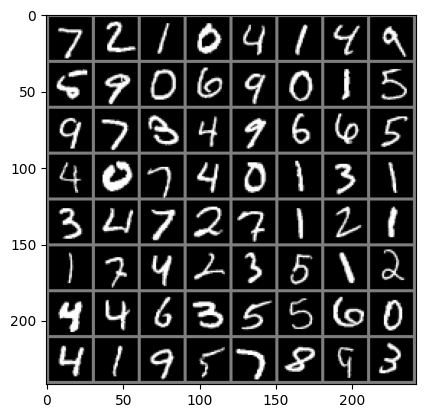

Predicted: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3]
Actual:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3]


In [45]:
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray") # Convert to HWC format
    plt.show()

# Get a batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Display images
imshow(torchvision.utils.make_grid(images))

# Get model predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Print predictions
print("Predicted:", predicted.cpu().numpy())
print("Actual:   ", labels.cpu().numpy())

##### Save model

In [46]:
# Save the trained model
torch.save(model.state_dict(), "mnist_model.pth")

# Load the model
model = NeuralNet()
model.to(device)
model.load_state_dict(torch.load("mnist_model.pth"))
model.eval()  # Set to evaluation mode

NeuralNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)